In [1]:
# Mount google drive files
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
# Install packages
!pip install git+https://github.com/seankmartin/NeuroChaT -q
!pip install git+https://github.com/seankmartin/PythonUtils -q
!pip install git+https://github.com/seankmartin/SIMURAN -q
!pip install git+https://github.com/seankmartin/lfp_atn -q
!pip install mne -q

In [10]:
# Import libraries
import os
import matplotlib.pyplot as plt

import simuran
from lfp_atn_simuran.analysis.frequency_analysis import powers
from tqdm.notebook import tqdm

In [4]:
# Configuration
path_dir = "/content/drive/My Drive/NeuroScience/ATN_CA1"
temp_storage_location = "/content/drive/My Drive/NeuroScience/Temp"
index_location = os.path.join(temp_storage_location, "index.csv")
mapping_params_location = os.path.join(temp_storage_location, "mapping.py")
os.makedirs(os.path.dirname(index_location), exist_ok=True)

nc_loader_kwargs = {
    "system": "Axona",
    "pos_extension": ".pos"
}

clean_kwargs = {
    "pick_property": "group",
    "channels": ["LFP"],
}

all_params = {
    # Cleaning params
    "clean_method": "pick",
    "clean_kwargs": clean_kwargs,
    
    # Filtering params
    "fmin": 1,
    "fmax": 100,
    "theta_min": 6,
    "theta_max": 10,
    "delta_min": 1.5,
    "delta_max": 4,

    # Plotting params
    "psd_scale": "decibels",
    "image_format": "png",

    # Path setup
    "cfg_base_dir" : "/content/drive/My Drive/NeuroScience/ATN_CA1",

    # STA
    "number_of_shuffles_sta": 5
}

In [5]:
# Write out the mapping file

def setup_signals():
    """Set up the signals (such as eeg or lfp)."""

    # The total number of signals in the recording
    num_signals = 32

    # What brain region each signal was recorded from
    regions = ["CA1"] * 32

    # If the wires were bundled, or any other kind of grouping existed
    # If no grouping, grouping = [i for in range(num_signals)]
    groups = ["LFP", "LFP", "LFP", "LFP"] + [i for i in range(num_signals - 4)]

    # The sampling rate in Hz of each signal
    sampling_rate = [250] * num_signals

    # This just passes the information on
    output_dict = {
        "num_signals": num_signals,
        "region": regions,
        "group": groups,
        "sampling_rate": sampling_rate,
    }

    return output_dict


def setup_units():
    """Set up the single unit data."""
    # The number of tetrodes, probes, etc - any kind of grouping
    num_groups = 8

    # The region that each group belongs to
    regions = ["CA1"] * num_groups

    # A group number for each group, for example the tetrode number
    groups = [1, 2, 3, 4, 9, 10, 11, 12]

    output_dict = {
        "num_groups": num_groups,
        "region": regions,
        "group": groups,
    }

    return output_dict


def setup_spatial():
    """Set up the spatial data."""

    output_dict = {
        "arena_size": "default",
    }
    return output_dict


def setup_loader():
    """
    Set up the loader and keyword arguments for the loader.

    See also
    --------
    simuran.loaders.loader_list.py

    """
    # The type of loader to use, see simuran.loaders.loader_list.py for options
    loader = "nc_loader"

    output_dict = {
        "loader": loader,
        "loader_kwargs": nc_loader_kwargs,
    }

    return output_dict


load_params = setup_loader()
mapping = {
    "signals": setup_signals(),
    "units": setup_units(),
    "spatial": setup_spatial(),
    "loader": load_params["loader"],
    "loader_kwargs": load_params["loader_kwargs"],
}

ph = simuran.ParamHandler(params=mapping)
ph.write(mapping_params_location)

In [6]:
# Index the files if not already done
def add_mapping_to_df(input_df, **kwargs):
    input_df["mapping"] = [os.path.basename(mapping_params_location)] * len(input_df)
    return input_df

files_df = simuran.index_ephys_files(
    path_dir,
    loader_name="neurochat",
    out_loc=index_location,
    post_process_fn=add_mapping_to_df,
    overwrite=False,
    post_process_kwargs=None,
    loader_kwargs=nc_loader_kwargs,
)

/content/drive/My Drive/NeuroScience/Temp/index.csv exists, so loading this - please delete to reindex or pass overwrite as True.


In [7]:
# Inspect the files_df
files_df

,filename,folder,time,duration,mapping
0,030419_open_arena_15min_LCA2.set,/content/drive/My Drive/NeuroScience/ATN_CA1/A...,13:05:2,900,mapping.py
1,090419_open_arena_15min_LCA2.set,/content/drive/My Drive/NeuroScience/ATN_CA1/A...,14:37:4,900,mapping.py
2,050419B_open_arena_15min_LCA2.set,/content/drive/My Drive/NeuroScience/ATN_CA1/A...,17:25:2,900,mapping.py
3,050419_open_arena_15min_LCA2.set,/content/drive/My Drive/NeuroScience/ATN_CA1/A...,15:30:2,900,mapping.py
4,190319_open_arena_15min_LCA2.set,/content/drive/My Drive/NeuroScience/ATN_CA1/A...,11:27:4,900,mapping.py
5,060419_open_arena_15min_LCA2.set,/content/drive/My Drive/NeuroScience/ATN_CA1/A...,18:10:4,900,mapping.py
6,220319_open_arena_15min_LCA2.set,/content/drive/My Drive/NeuroScience/ATN_CA1/A...,11:44:4,900,mapping.py
7,270319_open_arena_15min_LCA2.set,/content/drive/My Drive/NeuroScience/ATN_CA1/A...,14:55:0,900,mapping.py
8,22_10_19_LCA11_50min.set,/content/drive/My Drive/NeuroScience/ATN_CA1/A...,18:12:5,900,mapping.py
9,20_10_19_LCA11_15min.set,/content/drive/My Drive/NeuroScience/ATN_CA1/A...,20:09:3,900,mapping.py


In [8]:
# Parse the recording information
rc = simuran.recording_container_from_df(
    files_df,
    base_dir=path_dir,
    param_dir=temp_storage_location
    )

In [13]:
from skm_pyutils.py_log import get_default_log_loc

log_loc = get_default_log_loc("test.log")
print(log_loc)

/root/.skm_python/test.log


Excluded 2 signals with indices [0, 1]
Excluded 1 signals with indices [0]
Excluded 1 signals with indices [0]
Excluded 1 signals with indices [0]
Excluded 1 signals with indices [0]
Excluded 2 signals with indices [0, 1]
Excluded 2 signals with indices [1, 3]
Excluded 1 signals with indices [3]
Excluded 1 signals with indices [1]
Excluded 1 signals with indices [3]
Excluded 1 signals with indices [3]
Excluded 1 signals with indices [3]
Excluded 1 signals with indices [3]
Excluded 1 signals with indices [3]
Excluded 1 signals with indices [3]
Excluded 2 signals with indices [1, 2]
Excluded 1 signals with indices [1]
Excluded 2 signals with indices [1, 2]
Excluded 2 signals with indices [1, 2]


/usr/local/lib/python3.7/dist-packages/lfp_atn_simuran/analysis/frequency_analysis.py:212: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Excluded 1 signals with indices [1]


/usr/local/lib/python3.7/dist-packages/lfp_atn_simuran/analysis/frequency_analysis.py:212: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Excluded 1 signals with indices [1]


/usr/local/lib/python3.7/dist-packages/lfp_atn_simuran/analysis/frequency_analysis.py:212: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Excluded 1 signals with indices [1]


/usr/local/lib/python3.7/dist-packages/lfp_atn_simuran/analysis/frequency_analysis.py:212: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Excluded 1 signals with indices [2]


/usr/local/lib/python3.7/dist-packages/lfp_atn_simuran/analysis/frequency_analysis.py:212: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Excluded 2 signals with indices [0, 1]


/usr/local/lib/python3.7/dist-packages/lfp_atn_simuran/analysis/frequency_analysis.py:212: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Excluded 2 signals with indices [1, 2]


/usr/local/lib/python3.7/dist-packages/lfp_atn_simuran/analysis/frequency_analysis.py:212: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Excluded 2 signals with indices [1, 2]


/usr/local/lib/python3.7/dist-packages/lfp_atn_simuran/analysis/frequency_analysis.py:212: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Excluded 2 signals with indices [1, 2]


/usr/local/lib/python3.7/dist-packages/lfp_atn_simuran/analysis/frequency_analysis.py:212: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Excluded 2 signals with indices [1, 2]


/usr/local/lib/python3.7/dist-packages/lfp_atn_simuran/analysis/frequency_analysis.py:212: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Excluded 2 signals with indices [1, 2]


/usr/local/lib/python3.7/dist-packages/lfp_atn_simuran/analysis/frequency_analysis.py:212: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Excluded 1 signals with indices [2]


/usr/local/lib/python3.7/dist-packages/lfp_atn_simuran/analysis/frequency_analysis.py:212: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Excluded 1 signals with indices [1]



/usr/local/lib/python3.7/dist-packages/lfp_atn_simuran/analysis/frequency_analysis.py:212: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


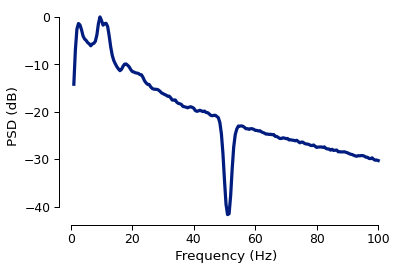

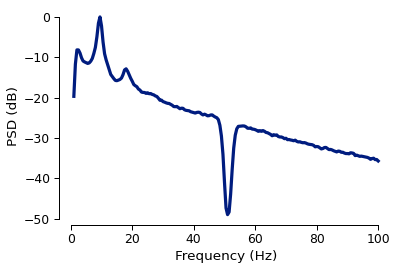

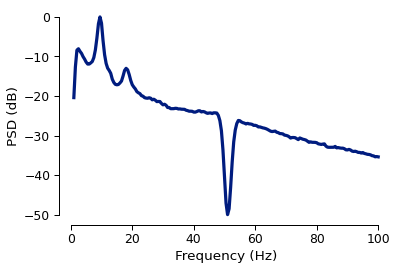

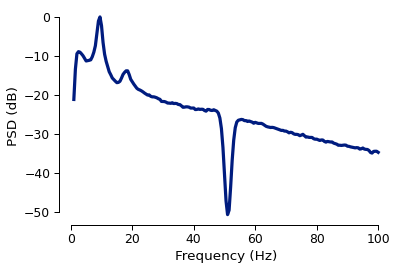

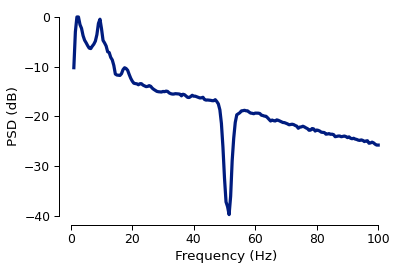

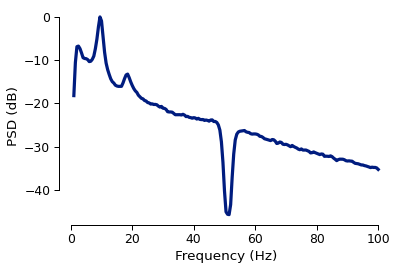

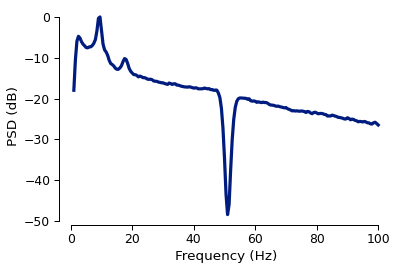

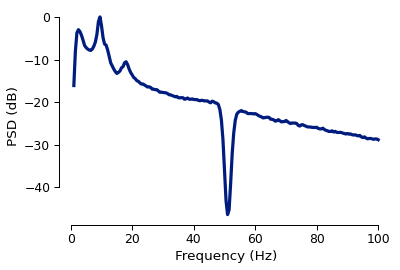

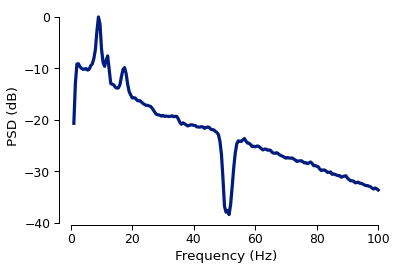

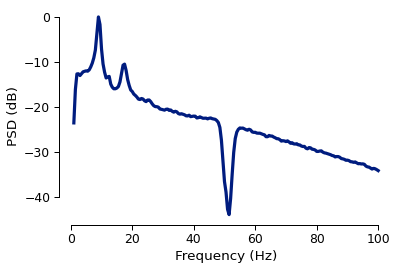

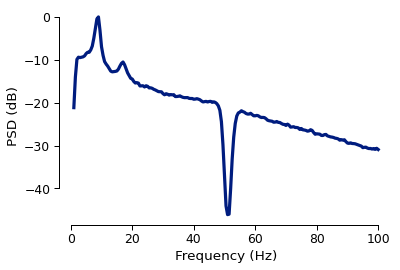

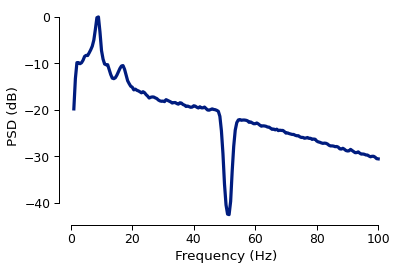

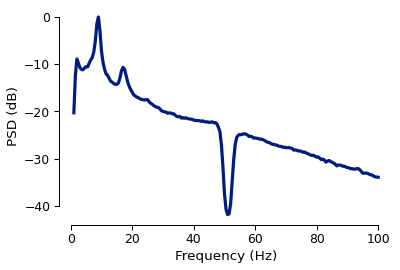

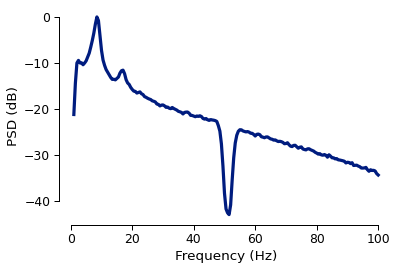

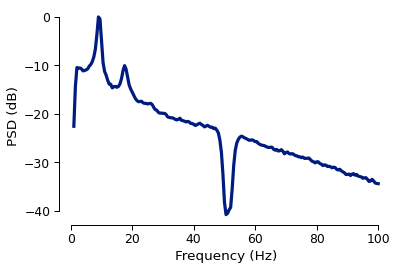

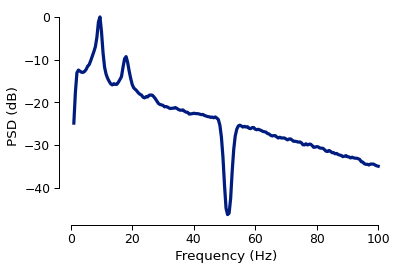

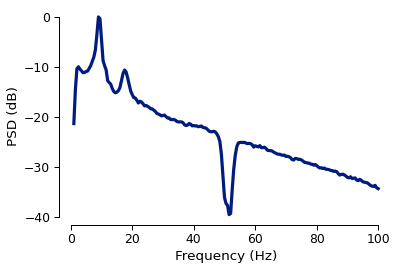

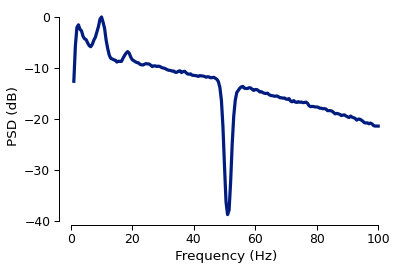

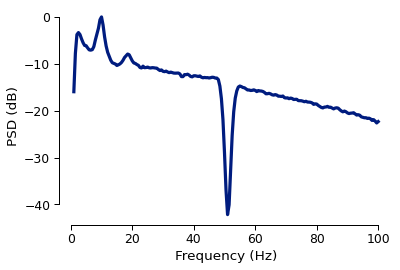

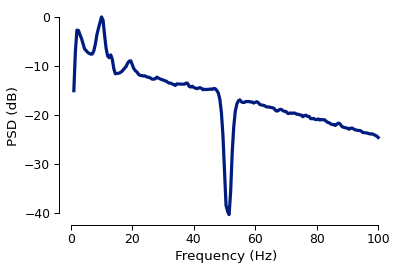

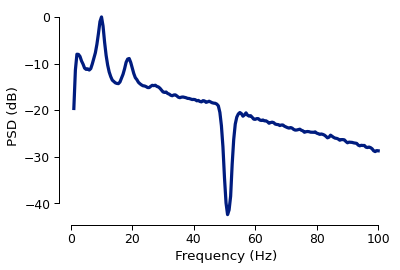

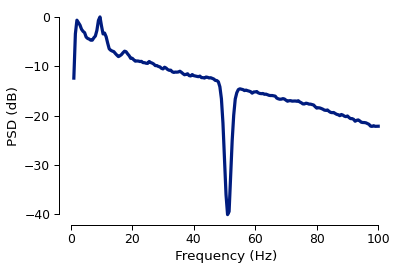

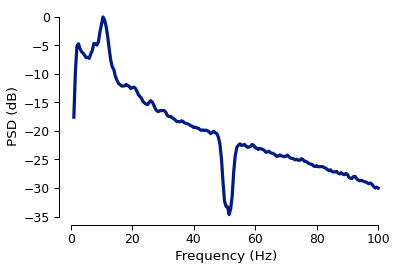

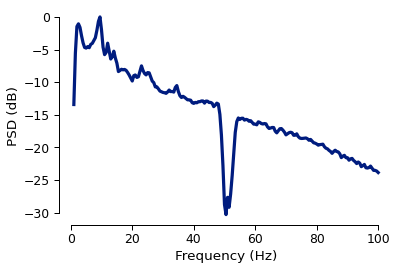

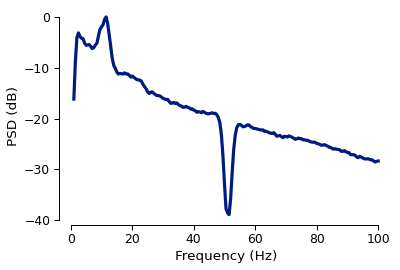

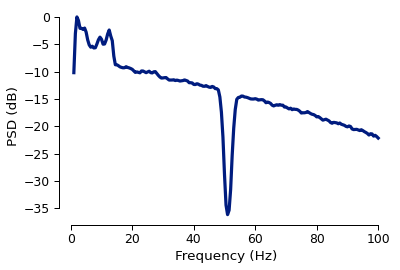

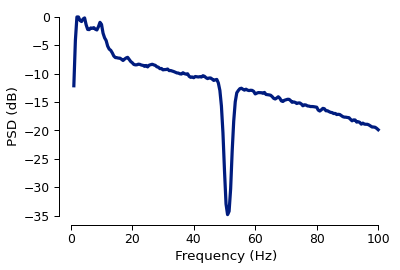

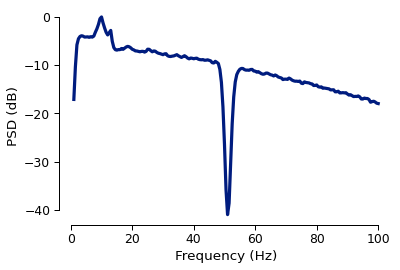

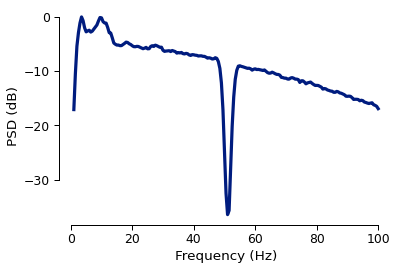

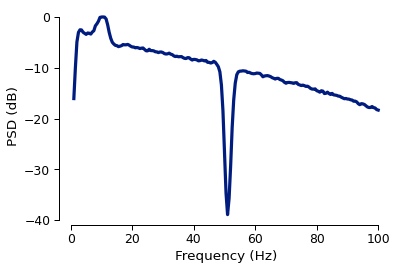

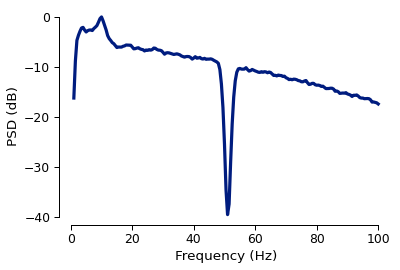

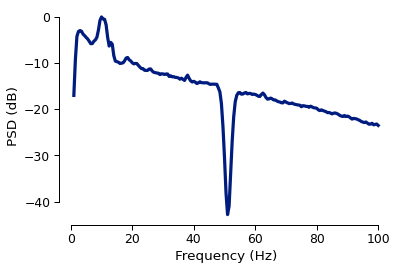

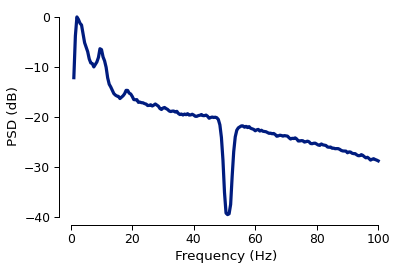

In [25]:
# Analyse each recording in the container
ah = simuran.AnalysisHandler(handle_errors=True)
sm_figures = []

fn_kwargs = all_params

for r in rc:
    for i in range(len(r.signals)):
        r.signals[i].load()
    fn_args = [r, path_dir, sm_figures]
    ah.add_fn(powers, *fn_args, **fn_kwargs)

ah.run_all_fns(pbar="notebook")

In [26]:
# Save the analysis results
print(ah)
simuran.save_figures(sm_figures, temp_storage_location, verbose=True)
ah.save_results(os.path.join(temp_storage_location, "results.csv"))

AnalysisHandler with functions:
 [<function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <function powers at 0x7f7c64c0a320>, <fun

INFO:stdout_logger:Plotting figures to /content/drive/My Drive/NeuroScience/Temp/plots


Plotting to ATNx_CA1_1--03_04--030419_open_arena_15min_LCA2_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_1--03_04--030419_open_arena_15min_LCA2_power_CA1.png


Plotting to ATNx_CA1_1--09_04--090419_open_arena_15min_LCA2_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_1--09_04--090419_open_arena_15min_LCA2_power_CA1.png


Plotting to ATNx_CA1_1--05_04--050419B_open_arena_15min_LCA2_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_1--05_04--050419B_open_arena_15min_LCA2_power_CA1.png


Plotting to ATNx_CA1_1--05_04--050419_open_arena_15min_LCA2_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_1--05_04--050419_open_arena_15min_LCA2_power_CA1.png


Plotting to ATNx_CA1_1--19_03--190319_open_arena_15min_LCA2_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_1--19_03--190319_open_arena_15min_LCA2_power_CA1.png


Plotting to ATNx_CA1_1--06_04--060419_open_arena_15min_LCA2_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_1--06_04--060419_open_arena_15min_LCA2_power_CA1.png


Plotting to ATNx_CA1_1--22_03--220319_open_arena_15min_LCA2_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_1--22_03--220319_open_arena_15min_LCA2_power_CA1.png


Plotting to ATNx_CA1_1--27_03--270319_open_arena_15min_LCA2_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_1--27_03--270319_open_arena_15min_LCA2_power_CA1.png


Plotting to ATNx_CA1_3--22_10--22_10_19_LCA11_50min_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_3--22_10--22_10_19_LCA11_50min_power_CA1.png


Plotting to ATNx_CA1_3--20_10--20_10_19_LCA11_15min_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_3--20_10--20_10_19_LCA11_15min_power_CA1.png


Plotting to ATNx_CA1_3--18_10--18_10_19_LCA11_15min_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_3--18_10--18_10_19_LCA11_15min_power_CA1.png


Plotting to ATNx_CA1_3--17_10--15_10_19_LCA11_15min_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_3--17_10--15_10_19_LCA11_15min_power_CA1.png


Plotting to ATNx_CA1_3--21_10--21_10_19_LCA11_15min_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_3--21_10--21_10_19_LCA11_15min_power_CA1.png


Plotting to ATNx_CA1_3--23_10--23_10_19_LCA11_rounded_10min_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_3--23_10--23_10_19_LCA11_rounded_10min_power_CA1.png


Plotting to ATNx_CA1_3--23_10--23_10_19_LCA11_smaill_10min_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_3--23_10--23_10_19_LCA11_smaill_10min_power_CA1.png


Plotting to ATNx_CA1_3--25_10--25_10_19_LCA11_15min_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_3--25_10--25_10_19_LCA11_15min_power_CA1.png


Plotting to ATNx_CA1_3--24_10--24_10_19_LCA11_15min_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_3--24_10--24_10_19_LCA11_15min_power_CA1.png


Plotting to ATNx_CA1_2--05_04--050419B_open_arena_15minutes_LCA3_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_2--05_04--050419B_open_arena_15minutes_LCA3_power_CA1.png


Plotting to ATNx_CA1_2--05_04--050419_open_arena_15minutes_LCA3_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_2--05_04--050419_open_arena_15minutes_LCA3_power_CA1.png


Plotting to ATNx_CA1_2--06_04--060419_open_arena_15minutes_LCA3_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_2--06_04--060419_open_arena_15minutes_LCA3_power_CA1.png


Plotting to ATNx_CA1_2--09_04--090419_open_arena_15minute_LCA3_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_2--09_04--090419_open_arena_15minute_LCA3_power_CA1.png


Plotting to ATNx_CA1_2--12_03--120319C_open_arena_15minutes_LCA3_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_2--12_03--120319C_open_arena_15minutes_LCA3_power_CA1.png


Plotting to ATNx_CA1_2--11_03--110319B_open_arena_15minutes_LCA3_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_2--11_03--110319B_open_arena_15minutes_LCA3_power_CA1.png


Plotting to ATNx_CA1_2--11_03--110319C_open_arena_15minutes_LCA3_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_2--11_03--110319C_open_arena_15minutes_LCA3_power_CA1.png


Plotting to ATNx_CA1_2--11_03--110319_open_arena_15minutes_LCA3_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_2--11_03--110319_open_arena_15minutes_LCA3_power_CA1.png


Plotting to ATNx_CA1_2--15_03--150319_open_arena_15minutes_LCA3_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_2--15_03--150319_open_arena_15minutes_LCA3_power_CA1.png


Plotting to ATNx_CA1_2--19_03--190319_open_arena_15minutes_LCA3_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_2--19_03--190319_open_arena_15minutes_LCA3_power_CA1.png


Plotting to ATNx_CA1_2--22_03--220319_open_arena_15minutes_LCA3_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_2--22_03--220319_open_arena_15minutes_LCA3_power_CA1.png


Plotting to ATNx_CA1_2--20_03--200319_open_arena_15minutes_LCA3_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_2--20_03--200319_open_arena_15minutes_LCA3_power_CA1.png


Plotting to ATNx_CA1_2--21_03--210319B_open_arena_15minutes_LCA3_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_2--21_03--210319B_open_arena_15minutes_LCA3_power_CA1.png


Plotting to ATNx_CA1_2--21_03--210319_open_arena_15minutes_LCA3_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_2--21_03--210319_open_arena_15minutes_LCA3_power_CA1.png


Plotting to ATNx_CA1_2--27_03--270319_open_arena_15minutes_LCA3_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_2--27_03--270319_open_arena_15minutes_LCA3_power_CA1.png


Plotting to ATNx_CA1_2--25_03--250319_open_arena_15minutes_LCA3_power_CA1.png


INFO:stdout_logger:Plotting to ATNx_CA1_2--25_03--250319_open_arena_15minutes_LCA3_power_CA1.png


Saving results to /content/drive/My Drive/NeuroScience/Temp/results.csv


In [23]:
# To see errors, use this
!ln -s /root/.skm_python /root/skm_python